In [2]:
from __future__ import division
import pandas as pd
import numpy as np
from matplotlib.patches import Polygon
import matplotlib
from matplotlib.collections import PatchCollection
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
# import fiona
from descartes import PolygonPatch
import matplotlib.pyplot as plt
from collections import defaultdict
# from matplotlib.path.Path import contains_points

In [4]:
# Create a Dataframe and drop extra column
df_new = pd.read_csv('./data/features_seattle_911_no_dup.csv', low_memory=False)
df_new.drop(['Unnamed: 0'], axis=1, inplace=True)
df_new.Datetime = pd.to_datetime(df_new.Datetime)



In [13]:
"""
100 -> 30 sec
500 -> 45 sec
1000 -> 45 sec
"""
df_test = df_new.ix[0:10000] 


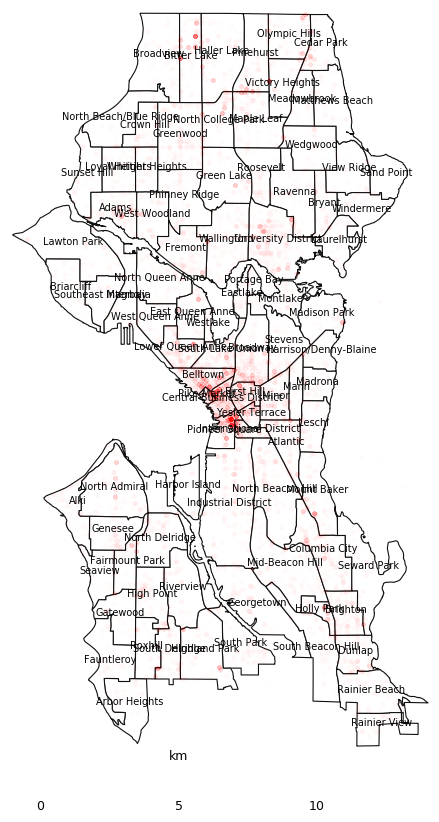

In [15]:

def plot_prepper(m, shapefilename, df_key):
    '''Generate dataframe for plotting'''
    _out = m.readshapefile(shapefilename, name='seattle', drawbounds=False, color='none', zorder=2)
    # set up a map dataframe for neighborhood outlines
    cent_lons = [float((Polygon(points).centroid.wkt).split()[1][1:]) for points in m.seattle]
    cent_lats = [float((Polygon(points).centroid.wkt).strip(')').split()[2]) for points in m.seattle]

    df = pd.DataFrame({
        'poly': [Polygon(points) for points in m.seattle],
        'name': [item[df_key] for item in m.seattle_info],
    })
    df['centroid_1'] = cent_lons
    df['centroid_2'] = cent_lats
    return _out, df

# Read in neighborhood shape file

hood_shapefilename = './neighborhoods_shape/WGS84/Neighborhoods'
hood_coords = (-122.43595589761988, 47.49551362397606, 
               -122.23604445458412, 47.73416494684497)

w, h = hood_coords[2] - hood_coords[0], hood_coords[3] - hood_coords[1]
extra = 0.005

# Initialize the plot
figwidth = 8
fig = plt.figure(figsize=(figwidth, figwidth*h/w))
ax = fig.add_subplot(111, axisbg='w', frame_on=False)
m = Basemap(
    projection='tmerc', ellps='WGS84',
    lon_0=np.mean([hood_coords[0], hood_coords[2]]),
    lat_0=np.mean([hood_coords[1], hood_coords[3]]),
    llcrnrlon=hood_coords[0] - extra * w,
    llcrnrlat=hood_coords[1] - (extra * h),
    urcrnrlon=hood_coords[2] + extra * w,
    urcrnrlat=hood_coords[3] + (extra * h),
    resolution='i',  suppress_ticks=True)

# get dataframe for plotting
_out, df_map = plot_prepper(m, hood_shapefilename, 'S_HOOD')
nbr_names = df_map['name'].unique()

# draw neighborhoods with grey outlines
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(x, ec='#111111', lw=.8, alpha=1., zorder=4))
pc = PatchCollection(df_map['patches'], match_original=True)
pc.set_facecolor('w')
ax.add_collection(pc)

# add parks
#park_shapefilename = '/Users/sydneydecoto/Documents/PythonScripts/City of Seattle Parks/WGS84/City_of_Seattle_Parks'

# get dataframe for plotting
#_out, df_map_park = plot_prepper(m, park_shapefilename, 'NAME')

# draw the parks
#df_map_park['patches'] = df_map_park['poly'].map(lambda x: PolygonPatch(x, ec='g',
#                                                 lw=.8, facecolor='g', alpha=.5, zorder=4))
#pp = PatchCollection(df_map_park['patches'], match_original=True)
#ax.add_collection(pp)

# Draw a map scale
m.drawmapscale(hood_coords[0] + 0.08, hood_coords[1] + -0.01, hood_coords[0], hood_coords[1], 10.,
               barstyle='fancy',
               fillcolor1='w', fillcolor2='#555555', zorder=5, ax=ax,)

# Read housing data from SQl table
# conn = psycopg2.connect(dbname='housingdata', user='sydneydecoto', host='/tmp')
# c = conn.cursor()
# c.execute('''
# SELECT lat FROM house_summary;''')
# lats = c.fetchall()
# c.execute('''SELECT long FROM house_summary;''')
# lons = c.fetchall()
# print '{} addresses collected'.format(len(lons))
# conn.commit()
# conn.close()

# Convert our latitude and longitude into Basemap cartesian map coordinates
# ld = pd.DataFrame(lats, columns=['latitude'])
# ld['longitude'] = lons

lons = df_test.Longitude
lats = df_test.Latitude

pt = []
xs = []
ys = []
'''This plots all the latitude/longitude points'''
for mapped_x, mapped_y in zip(lons, lats):
    xpt, ypt = m(mapped_x, mapped_y)
    plt.plot(xpt, ypt, '.', alpha=0.01, color='r')
    pt.append(Point(xpt, ypt))
    xs.append(xpt)
    ys.append(ypt)

Labels = []
dd = defaultdict(int)
xd = defaultdict(list)
yd = defaultdict(list)
nmlist = []

'''THIS IS THE PART THAT CHECKS WHICH NEIGHBORHOOD A POINT IS IN'''
for polygon in df_map['poly']:
    nm = df_map.loc[df_map['poly'] == polygon, 'name'].iloc[0]
    if len(nm.strip()) < 4 or nm in nmlist:
        continue
    dd[nm] = 0
    nmlist.append(nm)
    for i, p in enumerate(pt):
        Labels.append('notsure')
        if polygon.contains(p):
            Labels[i] = nm
            dd[nm] += 1
            xd[nm].append(xs[i])
            yd[nm].append(ys[i])

# Add neighborhood names
nml = []
for i, lon in enumerate(df_map['centroid_1'].values):
    if df_map['name'].values[i] in nml:
        continue
    nml.append(df_map['name'].values[i])
    if len(df_map['name'].values[i]) > 3:
        plt.text(lon, df_map['centroid_2'].values[i], df_map['name'].values[i], size=7, ha='center')

ax.axes.get_xaxis().set_visible(False)
plt.show()
